# Multiple Viewpoint Models

In [1]:
using CSV, DataFrames, Plots
using Chakra, Melch
include("src/Idyoms.jl")
using Main.Idyoms

### Initialise Melch data

In [2]:
Melch.__INIT__("/Users/nick/Work/MelchData")
nova = fnd(Melch.id(0),Melch)
melodies = pts(nova)
sequences = [sequence(pts(mel,Melch),Melch) for mel in melodies];

### Define Viewpoints

In [3]:
# Atomic Viewpoints
PITCH = vp(Melch.CPITCH);
DUR = vp(Melch.DUR);

# Difference Viewpoints
PDIFF = Chakra.diff(PITCH);
DDIFF = Chakra.diff(DUR);

# Linked Viewpoints
PITCH_X_DUR = link(PITCH,DUR);
PDIFF_X_DDIFF = link(PDIFF,DDIFF);

### Define the source and target viewpoints

In [4]:
# Target viewpoint: the viewpoint we want to predict.
trg = DUR;

# Source viewpoints: the viewpoints we wish to predict from. 
src = [PITCH,DUR,PDIFF,DDIFF];

### Generate Views from Viewpoints

In [5]:
# For each source viewpoint, we construct a view for each sequence.
views = [[View(seq,s,trg) for seq in sequences] for s in src];

### Generate predictions

In [6]:
a = Idyoms.get_alphabet(trg,sequences);
b = Interpolated()
e = A()
u = true
o = Bounded(5)

@time models = [Idyoms.ppm_both(v,a,b,e,u,o) for v in views];

  3.826425 seconds (71.32 M allocations: 8.401 GiB, 18.42% gc time, 17.25% compilation time)


In [7]:
weight = 0

@time m = Idyoms.combine_predictions(models,weight);

  0.183259 seconds (1.50 M allocations: 127.923 MiB, 6.55% gc time, 71.22% compilation time)


In [8]:
[Idyoms.mean_infcontent(m) for m in models]

4-element Vector{Float64}:
 1.709016380773396
 1.3519908056847634
 1.701177930282903
 1.4024012612320713

In [9]:
Idyoms.mean_infcontent(m)

1.4629036934216473

### Tabulate predictions

We can display the prediction sequences as data frames using the todataframe function.

In [10]:
tables = [Idyoms.todataframe(m) for m in models]
t = Idyoms.todataframe(m)

Row,SeqID,EventID,Symbol,Order,Prob,IC,H
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,1,24,0,0.241378,2.05063,3.33679
2,1,2,24,1,0.488687,1.03302,2.54561
3,1,3,12,2,0.160779,2.63685,2.25298
4,1,4,12,3,0.389379,1.36075,2.16799
5,1,5,12,4,0.442686,1.17564,1.99542
6,1,6,12,4,0.617341,0.69586,1.6996
7,1,7,24,4,0.314534,1.66871,1.78838
8,1,8,12,4,0.499065,1.0027,1.86043
9,1,9,12,4,0.506243,0.982099,1.93883


### Plot information content

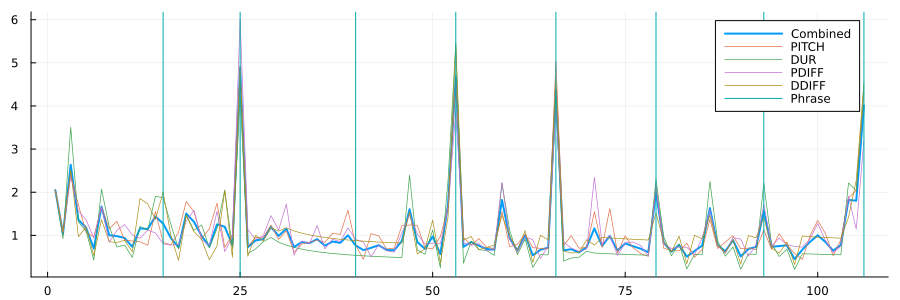

In [11]:
# Plot the IC of the combined model. 
plot(t.IC[1:106], lw=2, label="Combined")

# Plot the IC of each separate model
#for t in tables
#    plot!(t.IC[1:106], lw=0.7)
#end
ics = [t.IC[1:106] for t in tables];
plot!(ics,lw=0.7,labels=["PITCH" "DUR" "PDIFF" "DDIFF"])

# Extract phrase boundary information from sequences and plot them.
phrases = [e.PHRASE for e in vcat(sequences...)];
vline!(findall(x->x==-1,phrases[1:106]), lw = 1,label="Phrase")

plot!(size=(900,300))